In [1]:
# importing all required libraries
from imutils import paths
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import VGG16, ResNet152V2, Xception, InceptionResNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from keras.layers import Flatten, Dense, AveragePooling2D, Dropout, Input, BatchNormalization, Conv2D, Activation, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# dataset path
input_dir = "SMILEsmileD"
imagePaths = sorted(list(paths.list_images(input_dir)))

In [2]:
# looping thorugh all the image paths and storing the NumPy arrays of each image
# Determining the class names from the file path
image_data = []
labels = []

for path in imagePaths:
    image = cv2.imread(path)
    image = img_to_array(image)
    image_data.append(image)
    
    label = path.split("\\")[-3]
    if label == "negatives":
        label = "not smiling"
    else:
        label = "smiling"
    labels.append(label)

# Converting image data to numpy array
image_data = np.asarray(image_data) / 255.0

C:\Users\nvkanirudh\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


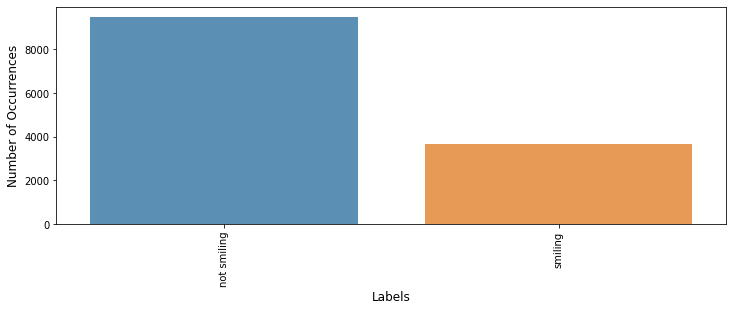

In [3]:
# Class Distribution
df = pd.DataFrame(labels, columns=["Labels"])
counts = df["Labels"].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(counts.index, counts.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Labels', fontsize=12)
plt.xticks(rotation=90)
plt.show();

# Converting labels to numpy array
labels = np.asarray(labels)

In [4]:
# Converting labels to numericals
from sklearn.preprocessing import LabelEncoder

lencoder = LabelEncoder()
lencoder.fit(labels)
labels = to_categorical(lencoder.transform(labels),2)

In [5]:
# Since the dataset is imbalanced, handling it by assigning weights to classes
classes = labels.sum(axis=0)
class_weights = {}

for i in range(len(classes)):
    class_weights[i] = classes.max() / classes[i]

class_weights

{0: 1.0, 1: 2.5677507}

In [6]:
# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, stratify=labels, random_state=42)

# Creating validation data
X_train = X_train[:-round(len(X_train)/10)]
y_train = y_train[:-round(len(y_train)/10)]
X_val = X_train[-round(len(X_train)/10):]
y_val = y_train[-round(len(y_train)/10):]

# ResNet50

In [7]:
# loading ResNet50 pre-trained model
keras_resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=X_train.shape[1:4])

# Creating custom FC layers
head = keras_resnet50.output
head = MaxPooling2D(pool_size=(2,2))(head)
head = Flatten()(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.5)(head)
head = Dense(2, activation='softmax')(head)

model = Model(inputs=keras_resnet50.input, outputs=head)

In [8]:
# Freezing the pre trained layers so that their weights don't get updated
for layer in keras_resnet50.layers:
    layer.trainable=False

# learning rate
lr = 0.001
epochs=15
opt = Adam(lr=0.001, decay=0.001 / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), class_weight=class_weights, batch_size=32)

C:\Users\nvkanirudh\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
297/297 [==============================] - 18s 27ms/step - loss: 0.9839 - accuracy: 0.5849 - val_loss: 0.6689 - val_accuracy: 0.5802
Epoch 2/15
297/297 [==============================] - 6s 21ms/step - loss: 0.8812 - accuracy: 0.6722 - val_loss: 0.6469 - val_accuracy: 0.6055
Epoch 3/15
297/297 [==============================] - 6s 21ms/step - loss: 0.8436 - accuracy: 0.6839 - val_loss: 0.5223 - val_accuracy: 0.7595
Epoch 4/15
297/297 [==============================] - 6s 21ms/step - loss: 0.8135 - accuracy: 0.7065 - val_loss: 0.7201 - val_accuracy: 0.5559
Epoch 5/15
297/297 [==============================] - 6s 21ms/step - loss: 0.7965 - accuracy: 0.7164 - val_loss: 0.4424 - val_accuracy: 0.7985
Epoch 6/15
297/297 [==============================] - 7s 22ms/step - loss: 0.7810 - accuracy: 0.7175 - val_loss: 0.4578 - val_accuracy: 0.8059
Epoch 7/15
297/297 [==============================] - 7s 22ms/step - loss: 0.7718 - accuracy: 0.7257 - val_loss: 0.4623 - val_accuracy: 0.792

Training Accuracy: 75.6
Validation Accuracy: 81.5


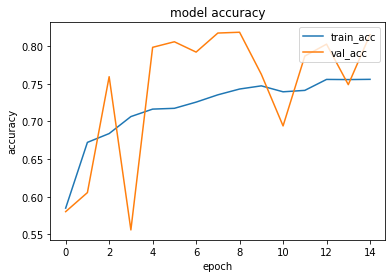

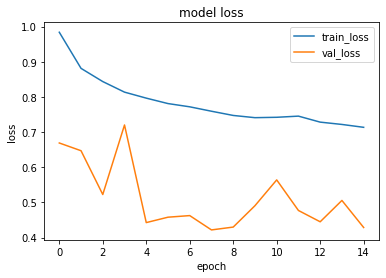

In [9]:
# Plotting loss and accuracy
print("Training Accuracy:", round(history.history['accuracy'][-1],3)*100)
print("Validation Accuracy:", round(history.history['val_accuracy'][-1],3)*100)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()



In [10]:
# Testing on test set and calculating accuracy
predictions = model.predict(X_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=lencoder.classes_))

              precision    recall  f1-score   support

 not smiling       0.90      0.79      0.84      1895
     smiling       0.59      0.77      0.67       738

    accuracy                           0.79      2633
   macro avg       0.75      0.78      0.76      2633
weighted avg       0.81      0.79      0.79      2633



In [11]:
# Haar Cascadde to detect faces in a given custom images
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# Testing smiling face
input_image = cv2.imread("smiling_face.jpg")
input_image = cv2.resize(input_image, (300, 300))

detects = detector.detectMultiScale(input_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, width, height) in detects:
    roi = input_image[y:y+height, x:x+width]
    roi = cv2.resize(roi, (64, 64))
    roi = roi/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    print(model.predict(roi))
    (notSmiling, smiling) = model.predict(roi)[0]
    if smiling > notSmiling:
        label = "smiling"
    else:
        label = "Not Smiling"
    print(label)
    
# Testing not smiling face
input_image = cv2.imread("not_smiling_face.jpg")
input_image = cv2.resize(input_image, (300, 300))

detects = detector.detectMultiScale(input_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, width, height) in detects:
    roi = input_image[y:y+height, x:x+width]
    roi = cv2.resize(roi, (64, 64))
    roi = roi/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    print(model.predict(roi))
    (notSmiling, smiling) = model.predict(roi)[0]
    if smiling > notSmiling:
        label = "smiling"
    else:
        label = "Not Smiling"
    print(label)

[[0.07841473 0.92158526]]
smiling
[[0.88794947 0.11205051]]
Not Smiling


# VGG16

In [12]:
# loading pre-trained VGG16 model
keras_vgg16 = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=X_train.shape[1:4]))

In [13]:
# Creating custom FC layers
head = keras_vgg16.output
head = MaxPooling2D(pool_size=(2,2))(head)
head = Flatten()(head)
head = Dense(256, activation='relu')(head) 
head = Dropout(0.5)(head)
head = Dense(2, activation='softmax')(head)

model = Model(inputs=keras_vgg16.input, outputs=head)

In [14]:
# Freezing the pre trained layers so that their weights don't get updated
for layer in keras_vgg16.layers:
    layer.trainable=False

lr = 0.0001
epochs=15
opt = Adam(lr=lr, decay=lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), class_weight=class_weights, batch_size=32)

C:\Users\nvkanirudh\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
297/297 [==============================] - 9s 25ms/step - loss: 0.9750 - accuracy: 0.6114 - val_loss: 0.5532 - val_accuracy: 0.7616
Epoch 2/15
297/297 [==============================] - 6s 21ms/step - loss: 0.8380 - accuracy: 0.7117 - val_loss: 0.5107 - val_accuracy: 0.7722
Epoch 3/15
297/297 [==============================] - 6s 21ms/step - loss: 0.7838 - accuracy: 0.7395 - val_loss: 0.4784 - val_accuracy: 0.8070
Epoch 4/15
297/297 [==============================] - 6s 21ms/step - loss: 0.7389 - accuracy: 0.7637 - val_loss: 0.4393 - val_accuracy: 0.8249
Epoch 5/15
297/297 [==============================] - 6s 21ms/step - loss: 0.7178 - accuracy: 0.7698 - val_loss: 0.4337 - val_accuracy: 0.8249
Epoch 6/15
297/297 [==============================] - 6s 21ms/step - loss: 0.6972 - accuracy: 0.7850 - val_loss: 0.4553 - val_accuracy: 0.8006
Epoch 7/15
297/297 [==============================] - 6s 22ms/step - loss: 0.6737 - accuracy: 0.7881 - val_loss: 0.3922 - val_accuracy: 0.8428

Training Accuracy: 81.5
Validation Accuracy: 84.8


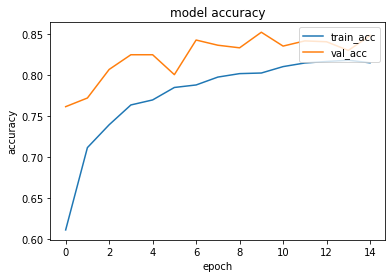

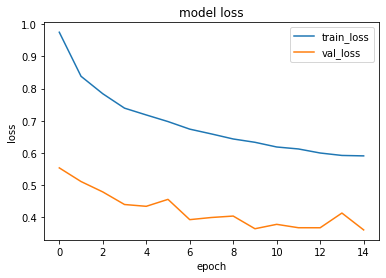

In [15]:
# Plotting loss and accuracy
print("Training Accuracy:", round(history.history['accuracy'][-1],3)*100)
print("Validation Accuracy:", round(history.history['val_accuracy'][-1],3)*100)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

In [16]:
# Testing on test set and calculating accuracy
predictions = model.predict(X_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=lencoder.classes_))

              precision    recall  f1-score   support

 not smiling       0.90      0.83      0.86      1895
     smiling       0.64      0.77      0.70       738

    accuracy                           0.81      2633
   macro avg       0.77      0.80      0.78      2633
weighted avg       0.83      0.81      0.82      2633



In [17]:
# Haar Cascadde to detect faces in a given custom images
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# Testing smiling face
input_image = cv2.imread("smiling_face (1).jpg")
input_image = cv2.resize(input_image, (300, 300))

detects = detector.detectMultiScale(input_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, width, height) in detects:
    roi = input_image[y:y+height, x:x+width]
    roi = cv2.resize(roi, (64, 64))
    roi = roi/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    print(model.predict(roi))
    (notSmiling, smiling) = model.predict(roi)[0]
    if smiling > notSmiling:
        label = "smiling"
    else:
        label = "Not Smiling"
    print(label)
    
# Testing not smiling face
input_image = cv2.imread("not_smiling_face.jpg")
input_image = cv2.resize(input_image, (300, 300))

detects = detector.detectMultiScale(input_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, width, height) in detects:
    roi = input_image[y:y+height, x:x+width]
    roi = cv2.resize(roi, (64, 64))
    roi = roi/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    print(model.predict(roi))
    (notSmiling, smiling) = model.predict(roi)[0]
    if smiling > notSmiling:
        label = "smiling"
    else:
        label = "Not Smiling"
    print(label)

[[0.9556336  0.04436636]]
Not Smiling
[[0.92608863 0.07391141]]
Not Smiling


# ResNet152V2

In [18]:
# loading pre-trained ResNet152V2 model
keras_resnet152V2 = ResNet152V2(weights="imagenet", include_top=False, input_shape=X_train.shape[1:4])

# Creating custom FC layers
head = keras_resnet152V2.output
head = MaxPooling2D(pool_size=(2,2))(head)
head = Flatten()(head)
head = Dense(256, activation='relu')(head) 
head = Dropout(0.5)(head)
head = Dense(2, activation='softmax')(head)

model = Model(inputs=keras_resnet152V2.input, outputs=head)

In [19]:
# Freezing the pre trained layers so that their weights don't get updated
for layer in keras_resnet152V2.layers:
    layer.trainable=False

lr = 0.0001
epochs=15
opt = Adam(lr=lr, decay=lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), class_weight=class_weights, batch_size=32)

C:\Users\nvkanirudh\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
297/297 [==============================] - 26s 63ms/step - loss: 1.0546 - accuracy: 0.6914 - val_loss: 0.4402 - val_accuracy: 0.8112
Epoch 2/15
297/297 [==============================] - 16s 53ms/step - loss: 0.6991 - accuracy: 0.7808 - val_loss: 0.3710 - val_accuracy: 0.8418
Epoch 3/15
297/297 [==============================] - 15s 51ms/step - loss: 0.6397 - accuracy: 0.8030 - val_loss: 0.3461 - val_accuracy: 0.8534
Epoch 4/15
297/297 [==============================] - 15s 51ms/step - loss: 0.5971 - accuracy: 0.8142 - val_loss: 0.3477 - val_accuracy: 0.8555
Epoch 5/15
297/297 [==============================] - 15s 51ms/step - loss: 0.5644 - accuracy: 0.8305 - val_loss: 0.3096 - val_accuracy: 0.8797
Epoch 6/15
297/297 [==============================] - 15s 51ms/step - loss: 0.5375 - accuracy: 0.8362 - val_loss: 0.2946 - val_accuracy: 0.8861
Epoch 7/15
297/297 [==============================] - 15s 50ms/step - loss: 0.5184 - accuracy: 0.8415 - val_loss: 0.2924 - val_accuracy:

Training Accuracy: 89.5
Validation Accuracy: 92.0


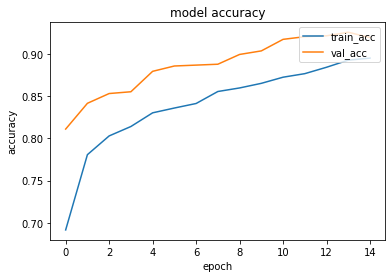

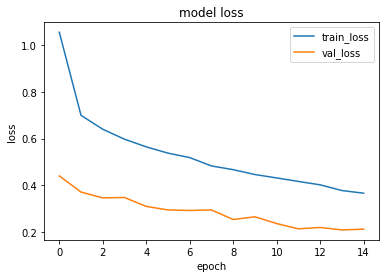

In [20]:
# Plotting loss and accuracy
print("Training Accuracy:", round(history.history['accuracy'][-1],3)*100)
print("Validation Accuracy:", round(history.history['val_accuracy'][-1],3)*100)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

In [21]:
# Testing on test set and calculating accuracy
predictions = model.predict(X_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=lencoder.classes_))

              precision    recall  f1-score   support

 not smiling       0.93      0.86      0.89      1895
     smiling       0.70      0.82      0.76       738

    accuracy                           0.85      2633
   macro avg       0.81      0.84      0.83      2633
weighted avg       0.86      0.85      0.86      2633



In [22]:
# Haar Cascadde to detect faces in a given custom images
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# Testing smiling face
input_image = cv2.imread("smiling_face (1).jpg")
input_image = cv2.resize(input_image, (300, 300))

detects = detector.detectMultiScale(input_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, width, height) in detects:
    roi = input_image[y:y+height, x:x+width]
    roi = cv2.resize(roi, (64, 64))
    roi = roi/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    print(model.predict(roi))
    (notSmiling, smiling) = model.predict(roi)[0]
    if smiling > notSmiling:
        label = "smiling"
    else:
        label = "Not Smiling"
    print(label)
    
# Testing not smiling face
input_image = cv2.imread("not_smiling_face.jpg")
input_image = cv2.resize(input_image, (300, 300))

detects = detector.detectMultiScale(input_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, width, height) in detects:
    roi = input_image[y:y+height, x:x+width]
    roi = cv2.resize(roi, (64, 64))
    roi = roi/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    print(model.predict(roi))
    (notSmiling, smiling) = model.predict(roi)[0]
    if smiling > notSmiling:
        label = "smiling"
    else:
        label = "Not Smiling"
    print(label)

[[0.02684645 0.97315353]]
smiling
[[9.9999845e-01 1.5524404e-06]]
Not Smiling


# Xception

In [23]:
# Resizing the image according to size specification of Xception
image_data = []

for path in imagePaths:
    image = cv2.imread(path)
    image = img_to_array(image)
    image = cv2.resize(image, (128, 128))
    image_data.append(image)

image_data = np.asarray(image_data) / 255.0

X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, stratify=labels, random_state=42)

X_train = X_train[:-round(len(X_train)/10)]
y_train = y_train[:-round(len(y_train)/10)]
X_val = X_train[-round(len(X_train)/10):]
y_val = y_train[-round(len(y_train)/10):]

In [24]:
# loading Xception pre-trained model
keras_xception = Xception(weights="imagenet", include_top=False, input_shape=X_train.shape[1:4])

# Creating custom FC layers
head = keras_xception.output
head = MaxPooling2D(pool_size=(2,2))(head)
head = Flatten()(head)
head = Dense(256, activation='relu')(head) 
head = Dropout(0.5)(head)
head = Dense(2, activation='softmax')(head)

model = Model(inputs=keras_xception.input, outputs=head)

In [25]:
# Freezing the pre trained layers so that their weights don't get updated
for layer in keras_xception.layers:
    layer.trainable=False

lr = 0.0001
epochs=15
opt = Adam(lr=lr, decay=lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), class_weight=class_weights, batch_size=32)

C:\Users\nvkanirudh\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
297/297 [==============================] - 19s 53ms/step - loss: 0.5800 - accuracy: 0.8175 - val_loss: 0.3285 - val_accuracy: 0.8586
Epoch 2/15
297/297 [==============================] - 15s 51ms/step - loss: 0.4830 - accuracy: 0.8558 - val_loss: 0.3357 - val_accuracy: 0.8470
Epoch 3/15
297/297 [==============================] - 15s 51ms/step - loss: 0.4453 - accuracy: 0.8677 - val_loss: 0.2876 - val_accuracy: 0.8703
Epoch 4/15
297/297 [==============================] - 15s 51ms/step - loss: 0.4229 - accuracy: 0.8755 - val_loss: 0.2429 - val_accuracy: 0.8861
Epoch 5/15
297/297 [==============================] - 15s 51ms/step - loss: 0.3924 - accuracy: 0.8862 - val_loss: 0.2604 - val_accuracy: 0.8871
Epoch 6/15
297/297 [==============================] - 15s 51ms/step - loss: 0.3809 - accuracy: 0.8880 - val_loss: 0.2513 - val_accuracy: 0.8945
Epoch 7/15
297/297 [==============================] - 15s 51ms/step - loss: 0.3709 - accuracy: 0.8904 - val_loss: 0.2218 - val_accuracy:

Training Accuracy: 91.9
Validation Accuracy: 93.7


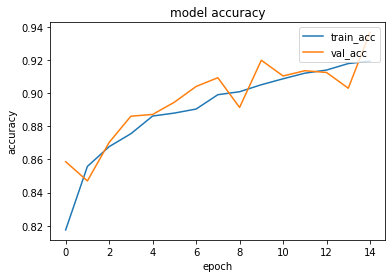

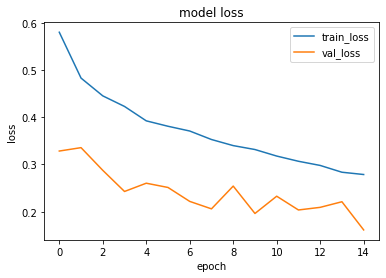

In [26]:
# Plotting loss and accuracy
print("Training Accuracy:", round(history.history['accuracy'][-1],3)*100)
print("Validation Accuracy:", round(history.history['val_accuracy'][-1],3)*100)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

In [27]:
# Testing on test set and calculating accuracy
predictions = model.predict(X_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=lencoder.classes_))

              precision    recall  f1-score   support

 not smiling       0.92      0.94      0.93      1895
     smiling       0.84      0.78      0.80       738

    accuracy                           0.89      2633
   macro avg       0.88      0.86      0.87      2633
weighted avg       0.89      0.89      0.89      2633



In [28]:
# Haar Cascadde to detect faces in a given custom images
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# Testing smiling face
input_image = cv2.imread("smiling_face (1).jpg")
input_image = cv2.resize(input_image, (300, 300))

detects = detector.detectMultiScale(input_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, width, height) in detects:
    roi = input_image[y:y+height, x:x+width]
    roi = cv2.resize(roi, (128, 128))
    roi = roi/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    print(model.predict(roi))
    (notSmiling, smiling) = model.predict(roi)[0]
    if smiling > notSmiling:
        label = "smiling"
    else:
        label = "Not Smiling"
    print(label)
    
# Testing not smiling face
input_image = cv2.imread("not_smiling_face.jpg")
input_image = cv2.resize(input_image, (300, 300))

detects = detector.detectMultiScale(input_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, width, height) in detects:
    roi = input_image[y:y+height, x:x+width]
    roi = cv2.resize(roi, (128, 128))
    roi = roi/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    print(model.predict(roi))
    (notSmiling, smiling) = model.predict(roi)[0]
    if smiling > notSmiling:
        label = "smiling"
    else:
        label = "Not Smiling"
    print(label)

[[0.34425536 0.6557446 ]]
smiling
[[9.99883533e-01 1.16493786e-04]]
Not Smiling


# InceptionResNetV2

In [29]:
# loading InceptionResnetV2 pre-trained model
keras_inceptionresnetv2 = InceptionResNetV2(weights="imagenet", include_top=False, input_shape=X_train.shape[1:4])

# creating custom FC layers
head = keras_inceptionresnetv2.output
head = MaxPooling2D(pool_size=(2,2))(head)
head = Flatten()(head)
head = Dense(256, activation='relu')(head) 
head = Dropout(0.5)(head)
head = Dense(2, activation='softmax')(head)

model = Model(inputs=keras_inceptionresnetv2.input, outputs=head)

In [30]:
# Freezing the pre trained layers so that their weights don't get updated
for layer in keras_inceptionresnetv2.layers:
    layer.trainable=False

lr = 0.0001
epochs=15
opt = Adam(lr=lr, decay=lr / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), class_weight=class_weights, batch_size=32)

C:\Users\nvkanirudh\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
297/297 [==============================] - 36s 92ms/step - loss: 0.8028 - accuracy: 0.7589 - val_loss: 0.4414 - val_accuracy: 0.8122
Epoch 2/15
297/297 [==============================] - 24s 79ms/step - loss: 0.6262 - accuracy: 0.8084 - val_loss: 0.3711 - val_accuracy: 0.8428
Epoch 3/15
297/297 [==============================] - 24s 79ms/step - loss: 0.5786 - accuracy: 0.8221 - val_loss: 0.3556 - val_accuracy: 0.8555
Epoch 4/15
297/297 [==============================] - 24s 79ms/step - loss: 0.5607 - accuracy: 0.8316 - val_loss: 0.3139 - val_accuracy: 0.8776
Epoch 5/15
297/297 [==============================] - 24s 80ms/step - loss: 0.5350 - accuracy: 0.8413 - val_loss: 0.3135 - val_accuracy: 0.8755
Epoch 6/15
297/297 [==============================] - 23s 79ms/step - loss: 0.5198 - accuracy: 0.8408 - val_loss: 0.3248 - val_accuracy: 0.8745
Epoch 7/15
297/297 [==============================] - 24s 80ms/step - loss: 0.4990 - accuracy: 0.8496 - val_loss: 0.2904 - val_accuracy:

Training Accuracy: 87.2
Validation Accuracy: 91.7


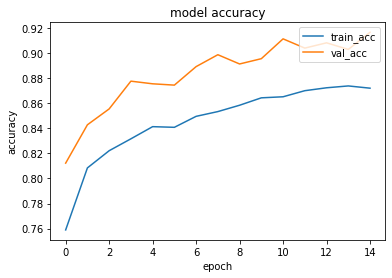

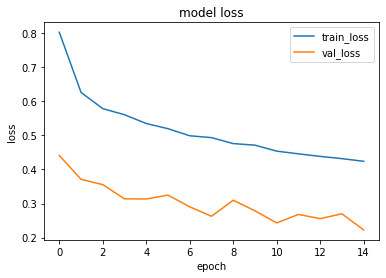

In [31]:
# Plotting loss and accuracy
print("Training Accuracy:", round(history.history['accuracy'][-1],3)*100)
print("Validation Accuracy:", round(history.history['val_accuracy'][-1],3)*100)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

In [32]:
# Testing on test set and calculating accuracy
predictions = model.predict(X_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=lencoder.classes_))

              precision    recall  f1-score   support

 not smiling       0.92      0.89      0.91      1895
     smiling       0.74      0.80      0.77       738

    accuracy                           0.87      2633
   macro avg       0.83      0.85      0.84      2633
weighted avg       0.87      0.87      0.87      2633



In [33]:
# Haar Cascadde to detect faces in a given custom images
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# Testing smiling face
input_image = cv2.imread("smiling_face (1).jpg")
input_image = cv2.resize(input_image, (300, 300))

detects = detector.detectMultiScale(input_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, width, height) in detects:
    roi = input_image[y:y+height, x:x+width]
    roi = cv2.resize(roi, (128, 128))
    roi = roi/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    print(model.predict(roi))
    (notSmiling, smiling) = model.predict(roi)[0]
    if smiling > notSmiling:
        label = "smiling"
    else:
        label = "Not Smiling"
    print(label)
    
# Testing not smiling face
input_image = cv2.imread("not_smiling_face.jpg")
input_image = cv2.resize(input_image, (300, 300))

detects = detector.detectMultiScale(input_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, width, height) in detects:
    roi = input_image[y:y+height, x:x+width]
    roi = cv2.resize(roi, (128, 128))
    roi = roi/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    print(model.predict(roi))
    (notSmiling, smiling) = model.predict(roi)[0]
    if smiling > notSmiling:
        label = "smiling"
    else:
        label = "Not Smiling"
    print(label)

[[0.01759451 0.9824055 ]]
smiling
[[0.9407875  0.05921246]]
Not Smiling


# LeNet Architecture

In [34]:
# Building LeNet5 architecture
def LeNet(width, height, channels, classes):
    input_shape = (width, height, channels)
    
    model = Sequential()
    
    model.add(Conv2D(6, 5, padding="same", input_shape=input_shape))
    model.add(Activation("tanh"))
    model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(16, 5, padding="same", input_shape=input_shape))
    model.add(Activation("tanh"))
    model.add(AveragePooling2D(pool_size=(2,2), strides=(2,2)))
    
    model.add(Conv2D(120, 5, padding="same", input_shape=input_shape))
    model.add(Activation("tanh"))
    
#     Fully Connected layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("tanh"))
    
#     Last FC layer
    model.add(Dense(classes))
    model.add(Activation("softmax"))
    
    return model

image_data = []

for path in imagePaths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (28, 28))
    image = img_to_array(image)
    
    image_data.append(image)
    

image_data = np.asarray(image_data) / 255.0
X_train, X_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, stratify=labels, random_state=42)

X_train = X_train[:-round(len(X_train)/10)]
y_train = y_train[:-round(len(y_train)/10)]
X_val = X_train[-round(len(X_train)/10):]
y_val = y_train[-round(len(y_train)/10):]
X_train.shape

(9479, 28, 28, 1)

In [35]:
model = LeNet(28, 28, 1, 2)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=15, validation_data=(X_val, y_val), class_weight=class_weights, batch_size=32)

Epoch 1/15
297/297 [==============================] - 5s 8ms/step - loss: 0.7419 - accuracy: 0.7507 - val_loss: 0.3540 - val_accuracy: 0.8597
Epoch 2/15
297/297 [==============================] - 2s 7ms/step - loss: 0.5680 - accuracy: 0.8248 - val_loss: 0.3260 - val_accuracy: 0.8776
Epoch 3/15
297/297 [==============================] - 2s 7ms/step - loss: 0.5567 - accuracy: 0.8306 - val_loss: 0.3311 - val_accuracy: 0.8703
Epoch 4/15
297/297 [==============================] - 2s 7ms/step - loss: 0.5522 - accuracy: 0.8306 - val_loss: 0.3297 - val_accuracy: 0.8724
Epoch 5/15
297/297 [==============================] - 2s 6ms/step - loss: 0.5418 - accuracy: 0.8351 - val_loss: 0.3536 - val_accuracy: 0.8534
Epoch 6/15
297/297 [==============================] - 2s 6ms/step - loss: 0.5353 - accuracy: 0.8398 - val_loss: 0.3935 - val_accuracy: 0.8143
Epoch 7/15
297/297 [==============================] - 2s 6ms/step - loss: 0.5342 - accuracy: 0.8369 - val_loss: 0.3404 - val_accuracy: 0.8470
Epoch 

Training Accuracy: 87.6
Validation Accuracy: 89.0


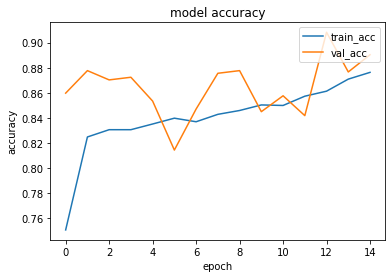

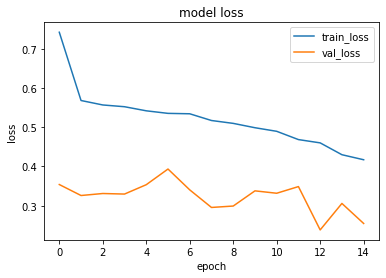

In [36]:
# Plotting loss and accuracy
print("Training Accuracy:", round(history.history['accuracy'][-1],3)*100)
print("Validation Accuracy:", round(history.history['val_accuracy'][-1],3)*100)
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper right')
plt.show()

In [37]:
# Testing on test set and calculating accuracy
predictions = model.predict(X_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=lencoder.classes_))

              precision    recall  f1-score   support

 not smiling       0.94      0.83      0.88      1895
     smiling       0.67      0.87      0.76       738

    accuracy                           0.84      2633
   macro avg       0.81      0.85      0.82      2633
weighted avg       0.87      0.84      0.85      2633



In [38]:
# Haar Cascadde to detect faces in a given custom images
detector = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
# Testing smiling face
input_image = cv2.imread("smiling_face (1).jpg")
input_image = cv2.resize(input_image, (300, 300))
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

detects = detector.detectMultiScale(input_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, width, height) in detects:
    roi = input_image[y:y+height, x:x+width]
    roi = cv2.resize(roi, (28, 28))
    roi = roi/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    print(model.predict(roi))
    (notSmiling, smiling) = model.predict(roi)[0]
    if smiling > notSmiling:
        label = "smiling"
    else:
        label = "Not Smiling"
    print(label)
    
# Testing not smiling face
input_image = cv2.imread("not_smiling_face.jpg")
input_image = cv2.resize(input_image, (300, 300))
input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)

detects = detector.detectMultiScale(input_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30), flags=cv2.CASCADE_SCALE_IMAGE)
for (x, y, width, height) in detects:
    roi = input_image[y:y+height, x:x+width]
    roi = cv2.resize(roi, (28, 28))
    roi = roi/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    print(model.predict(roi))
    (notSmiling, smiling) = model.predict(roi)[0]
    if smiling > notSmiling:
        label = "smiling"
    else:
        label = "Not Smiling"
    print(label)

[[0.01016321 0.98983675]]
smiling
[[0.99729604 0.00270394]]
Not Smiling


Text(0, 0.5, 'Accuracy')

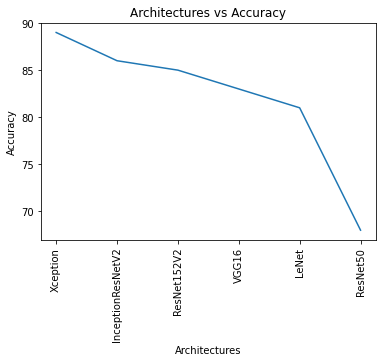

In [39]:
# Plotting testing accuracies of all the architectures
accuracies = [68, 83, 85, 89, 86, 81]
X = ["Xception", "InceptionResNetV2", "ResNet152V2", "VGG16", "LeNet", "ResNet50"]
y = sorted(accuracies, reverse=True)

plt.plot(X,y)
plt.xticks(rotation=90)
plt.title("Architectures vs Accuracy")
plt.xlabel("Architectures")
plt.ylabel("Accuracy")